# DengAI
This project comes from the challenge proposed by [DRIVENDATA](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/). The goal consists of predicting how many dengue fever cases occur in two different cities. In order to do so, they provide a set of standard features that include aspects such as temperature, level of vegetation, etc.

It is important to state that since our intention is to predict the number of cases this is a regression problem. However, if we quantize the ```y``` labels we might also consider a classification problem, although we leave such task for another analysis.

---
Antonio Rodríguez-Hidalgo (arodh91@gmail.com)

2020

## Reading data

In [1]:
import pandas as pd
import os
import numpy as np

def read_data(data_file):
    data_structure = pd.read_csv(os.path.join('data',data_file))
    return data_structure

features = read_data('dengue_features_train.csv');
labels = read_data('dengue_labels_train.csv');
print('Training data readed!')

# We mix features and labels in a single dataset for commodity
features['total_cases']=labels['total_cases']
# Number of cities
print('Cities: {}'.format(features.city.unique()))


Training data readed!
Cities: ['sj' 'iq']


In order to grasp the dataset we focus on one of the cities. Then, we can replicate our analyses with the other one.

In [2]:
# We split data for the two cities
city = 'sj'; # sj, iq
city_data = features[features['city'] == city]
labels = labels[labels['city'] == city]

city_data.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

# Data imputation
We check out how many of the features are missing (NaN) columnwise. It is important to appoint such values, since models might be affected by those points.

In [3]:
missing = {}
for col in city_data:
    missing_no = city_data[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;

pd.DataFrame(missing.values(), index = missing.keys(), columns=['Number of missing elements'])

,Number of missing elements
ndvi_ne,191
ndvi_nw,49
ndvi_se,19
ndvi_sw,19
precipitation_amt_mm,9
reanalysis_air_temp_k,6
reanalysis_avg_temp_k,6
reanalysis_dew_point_temp_k,6
reanalysis_max_air_temp_k,6
reanalysis_min_air_temp_k,6


We observe that some of these could be estimated using alternative features. That is hte example of "station_avg_temp_c", which could be estimated using "station_max_temp_c" and "station_min_temp_c" if they existed. Same could happen with "reanalysis_avg_temp_k". 

Nevertheless, since we are working with temporal series data it seems reasonable enough to interpolate the missing values using the data that we already know. This might be effective if the missing values are sparsely distributed.

In [4]:
for col in missing.keys():
    # We don't use the 'inplace' parameter since it shows the SettingWithCopyWarning.
    city_data[col].values[:] = city_data[col].interpolate(inplace=False)

# New features
We infer some features that might be interesting: 
* ```day``` 
* ```month``` 

using ```week_start_date```. We remove the latter, and also ```city``` since we will perform our regression considering each city separatedly.



In [5]:
city_data.insert(1, 'month', 0)
city_data.insert(1, 'day', 0)
city_data['month'].values[:] = city_data.apply(lambda x: int(x['week_start_date'][5:7]), axis=1);
city_data['day'].values[:] = city_data.apply(lambda x: int(x['week_start_date'][8:10]), axis=1);
city_data.pop('week_start_date');
city_data.pop('city');


We include a feature that might be interesting, which is the ```season```. Considering that there are four seasons (spring, summer, autumn, winter), we provide a numerical label for each one of them. The underlying idea is that depending on the month, we will code a new feature indicating the season under analysis. This is clearly a periodic feature, which is potentially relatable with the number ```total_cases```.

![Image](https://images.theconversation.com/files/253677/original/file-20190114-43517-11n11cr.jpg?ixlib=rb-1.1.0&rect=149%2C4%2C2318%2C1580&q=45&auto=format&w=496&fit=clip)

In [6]:
# We define the four seasons from the North hemishpere. 
def season(input_data):
    input_data = int(input_data)
    if (input_data >=1) & (input_data <=3): # Winter        
        output = 4;        
    if (input_data >=4) & (input_data <=6): # Spring        
        output = 1;
    if (input_data >=7) & (input_data <=9): # Summer        
        output = 2;
    if (input_data >=10) & (input_data <=12): # Autumn/Fall        
        output = 3;
    return output

city_data.insert(1,'season', 0);
city_data['season'].values[:] = city_data['month'].apply(season);



We also design a function that allows us to include a certain context. That is, our features would be formed not only by current data (in a certain time ```t```), but also by previous values (```t-1```, ```t-2```, etc.). However, we don't make extensive use of this function for now.

In [7]:
def context_extractor(data_structure):
    alt_data_structure = data_structure[:];
    
    col_names = [i for i in data_structure.columns  if i not in ['total_cases','total_cases_LOG','diff','pos_neg']]
    lag = 1;
    col_names_lag = [i+'_'+str(lag) for i in col_names]
    
    alt_data_structure[col_names_lag] = city_data[col_names]
    alt_data_structure['weekofyear_1'] = alt_data_structure['weekofyear_1'].shift(1)

            
    return alt_data_structure


# Time plot

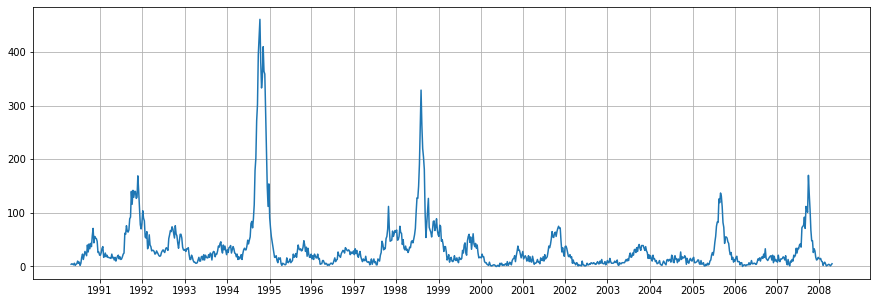

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(city_data['total_cases'])
plt.xticks(city_data.loc[city_data['weekofyear']== 1]['year'].index, labels = city_data.loc[city_data['weekofyear']== 1]['year']);
plt.grid()

Having a look at the temporal data shows that there are certain years where there were plenty of cases of Denge, as it occurred during 1994 and 1998. Moreover, we observe some seasonal effect, since there is a significant increase in the number of cases normally after mid-year. Consequently, we will attempt to have a deeper grasp of this effect.

# Seasonal analysis
We perform a seasonal plot inspired in the following work:
https://www.machinelearningplus.com/time-series/time-series-analysis-python/

We compute first the number of monthly cases. Then, we represent information from each year individually.

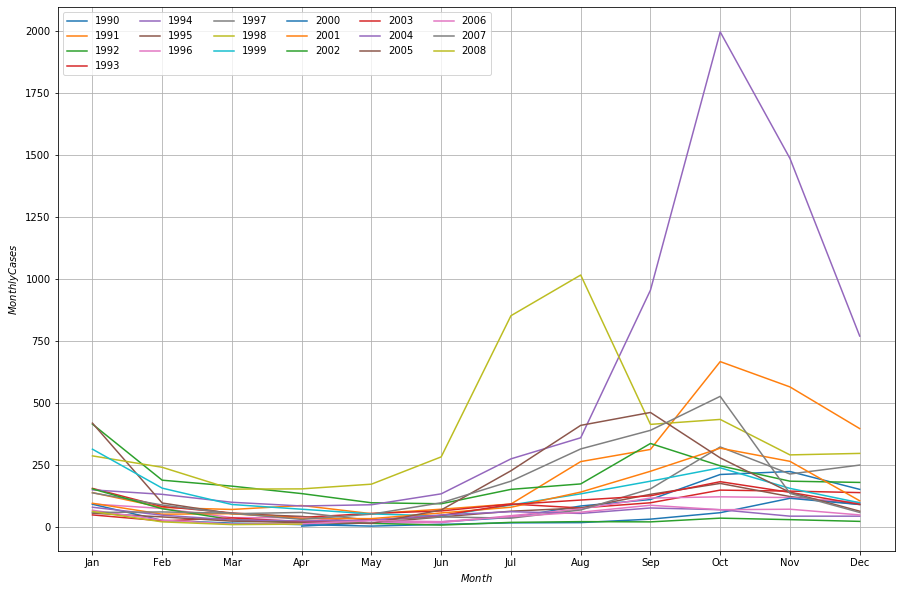

In [9]:
years = city_data['year'].unique()
anual_data = {};
plt.figure(figsize=(15,10))
for i, y in enumerate(years):
    # Here we compute monthly information.
    anual_data[y] = city_data.loc[city_data['year'] == y][['month','total_cases']].groupby('month').sum()    
    
    # Here we represent the plots.
    plt.plot((anual_data[y]), label=y)
    plt.xticks(np.arange(1,13),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    
    
plt.gca().set(xlim=(0.5, 12.5), ylabel='$Monthly Cases$', xlabel='$Month$')
plt.legend(ncol=6)
plt.grid()

We can observe that the number of cases is low between February and May. Afterwards, depending of the year there is an increase in such number whose magnitude might depend on other variables that we will study later. However, it is confirmed that there is certain degree of seasonality which can probably be related with weather events.

# Pairplot

In [10]:
import seaborn as sns
# sns_plot = sns.pairplot(city_data);
# sns_plot.savefig("Pairplot.png")

The pairplot shows that the relationship between some of the features is clearly linear. Consequently, we could remove some of the elements forming such couples since they do not provide any additional info to the analysis. We remove one element from each of the following couples: 
* `precipitation_amt_mm` - `reanalysis_sat_precip_amt_mm`
* `reanalysis_air_temp_k` - `reanalysis_avg_temp_k`
* `reanalysis_dew_point_temp_k` - `reanalysis_specific_humidity_g_per_kg`
* `month` - `weekofyear` - `season` 
We remove some of them. 

In [11]:
city_data = city_data[[col for col in city_data.columns if col not in ['precipitation_amt_mm','reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k','weekofyear','season']]]

In [12]:
# sns_plot = sns.pairplot(city_data);
# sns_plot.savefig("Pairplot_corrected.png")

We can observe the effect of some discrete variables such as the `year` or the `month`, which do show discrete distribution values.

# Studying correlation
It is quite important to understand what is the correlation between our existing features. An interesting fact is that correlation allows to measure some degree of similarity in a linear way, which means that two features that show a big value of such score can be linearly obtained from each other. This means that using features with a significant degree of correlation might worsen the performance of a model, since we would be feeding it using data that is redundant. Consequently, we need to minimize the number of features that are strongly correlated.

On the contrary, features that are highly correlated with the labels, denoted ```total_cases```, are highly desirable since they can be helpful to make our predictions.

In [13]:
# We study each feature independently and how it relates with the rest
from DengAI_utils import compute_correlation
correlation_matrix = compute_correlation(city_data);

We can observe that some of the features are strongly correlated, as it happens with ```ndvi_``` features and ```reanalysis_air_temp_k``` and ```reanalysis_avg_temp_k```.

If we focus on the correlation between ```total_cases``` and our feature-set we obtain the following graph, which depicts that for the ```city=iq``` the top features are ```season```, a humidity variable and three temperature variables. Notice that these will change for ```city=sj```.

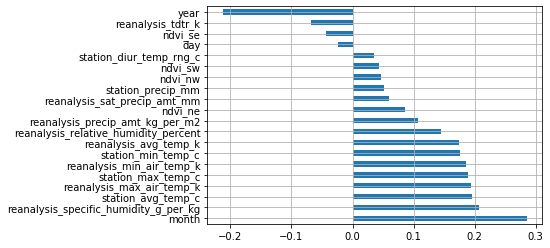

In [14]:
correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh();
plt.grid()

We can get a ranking with such scores and use it later to train our model.

In [15]:
sorted_features = correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False)
sorted_features[:7]

month                                    0.285754
reanalysis_specific_humidity_g_per_kg    0.206942
station_avg_temp_c                       0.194823
reanalysis_max_air_temp_k                0.193233
station_max_temp_c                       0.188447
reanalysis_min_air_temp_k                0.186539
station_min_temp_c                       0.175248
Name: total_cases, dtype: float64

We will check out the degree of correlation of all these features against each other. It should be appointed that some features are clearly going to have cyclic relationships, such as it happens with `month` and temperatures. Moreover, other features are going to be more linearly related, such as humidity and temperature.

Thanks to a more detailed view we can see that there is no linear relationship between `total_cases` and any of the features.



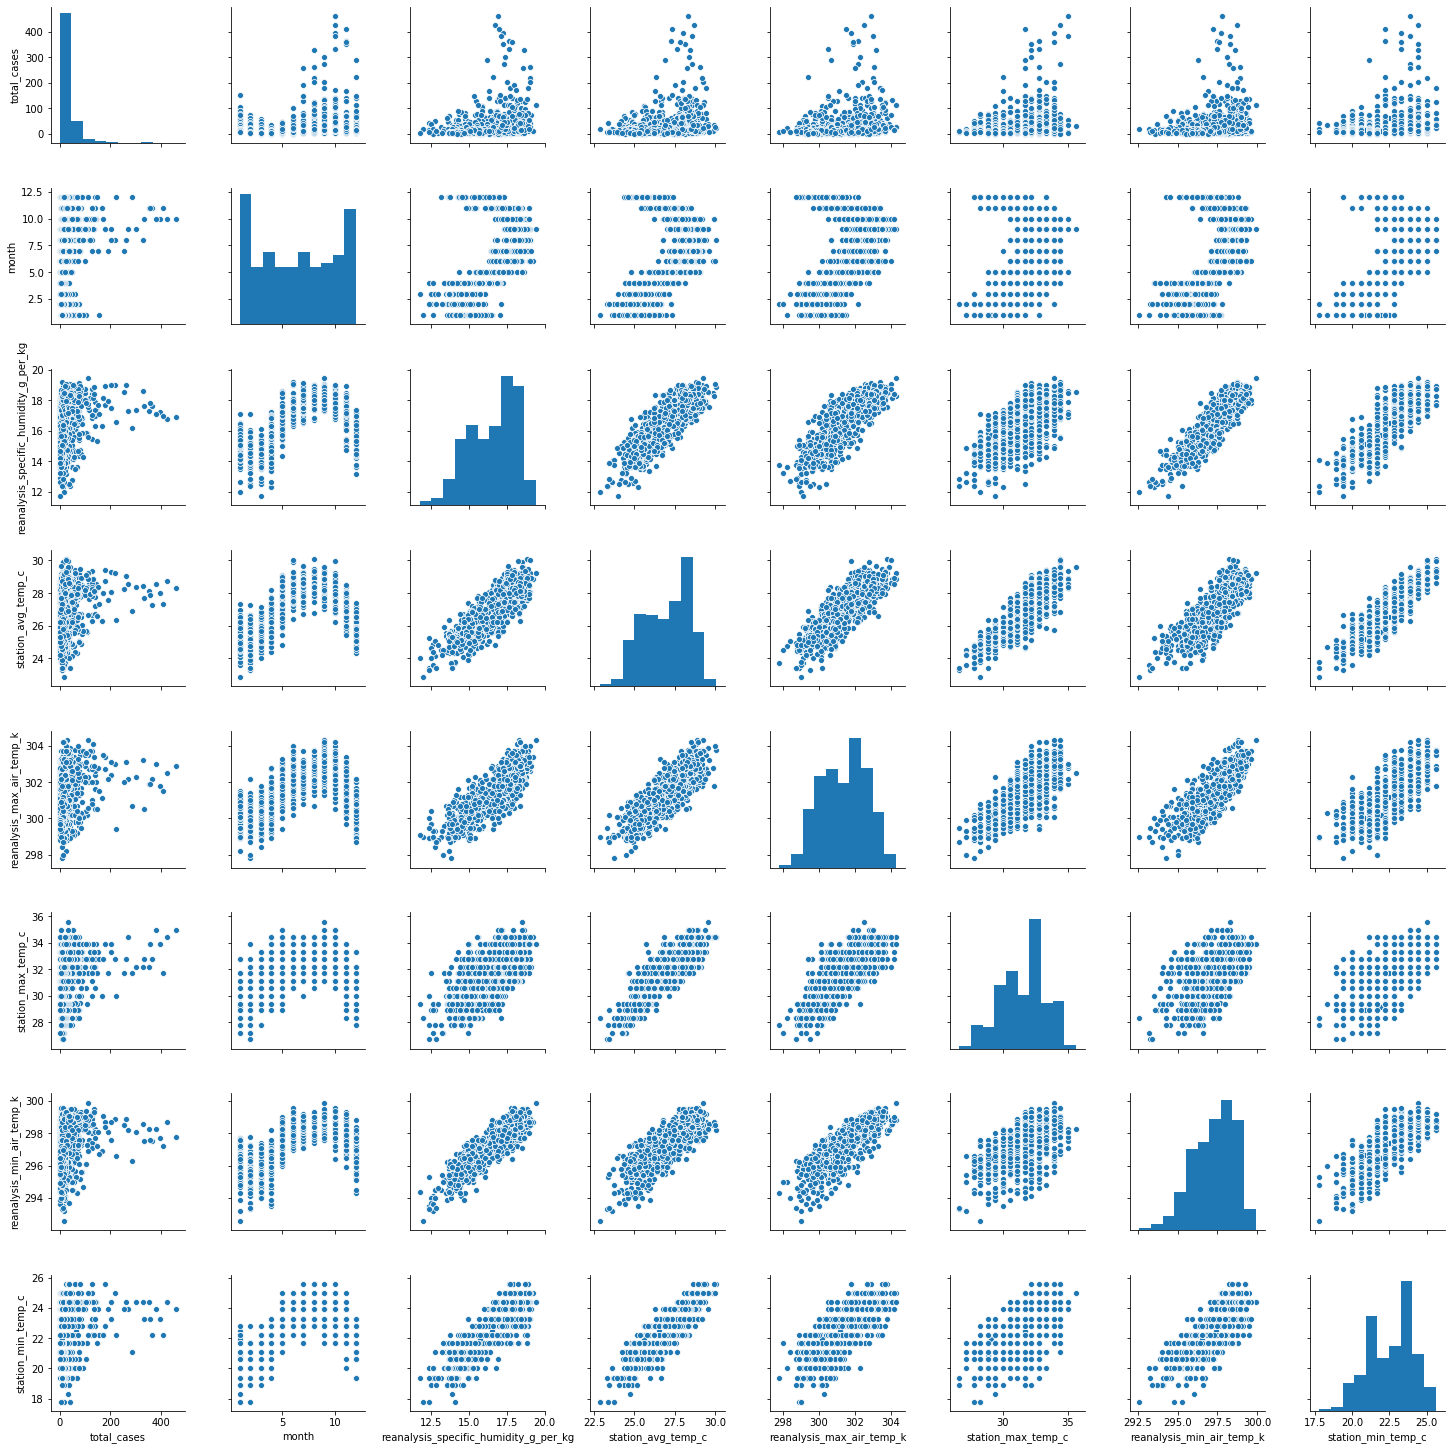

In [16]:
sorted_features = correlation_matrix.total_cases.sort_values(ascending=False)
sns_plot = sns.pairplot(city_data[sorted_features.index[:8]]);

# Poly features
Alternative features can be computed using polynomic functions. We select some of the features and attempt to extract a new set using their polynomic combinations.

In [17]:
selected_features = ['weekofyear','month','inverse_year','reanalysis_specific_humidity_g_per_kg','reanalysis_dew_point_temp_k','station_avg_temp_c','reanalysis_max_air_temp_k']
from ML_utils.FeatureExtraction import FeatureExtraction
feature_extractor = FeatureExtraction();
feature_extractor.polynomial(9);
feature_extractor.fit(city_data[[i for i in city_data.columns if i in selected_features]])
poly_feat = pd.DataFrame(feature_extractor.transform(city_data[[i for i in city_data.columns if i in selected_features]], 'poly'))

poly_feat['total_cases'] = city_data['total_cases']
sorted_features = (poly_feat.corr()
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))
poly_selection = sorted_features[:1].keys()

n_poly = 1;
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
aux = scaler.fit_transform( poly_feat[sorted_features[:n_poly].keys()])

for i in range(n_poly):
    city_data['poly_{}'.format(i)] = aux[:,i]

In the city we are analysing, it seems that ```poly_0``` is working reasonably well. Notice that such polynomia was computed after studying different combinations until the 9th degree.

# PCA

Since we still observe some linear relationships between some of the features, it might be interesting to project them into an alternate space where components are uncorrelated. We use PCA for such purpose.

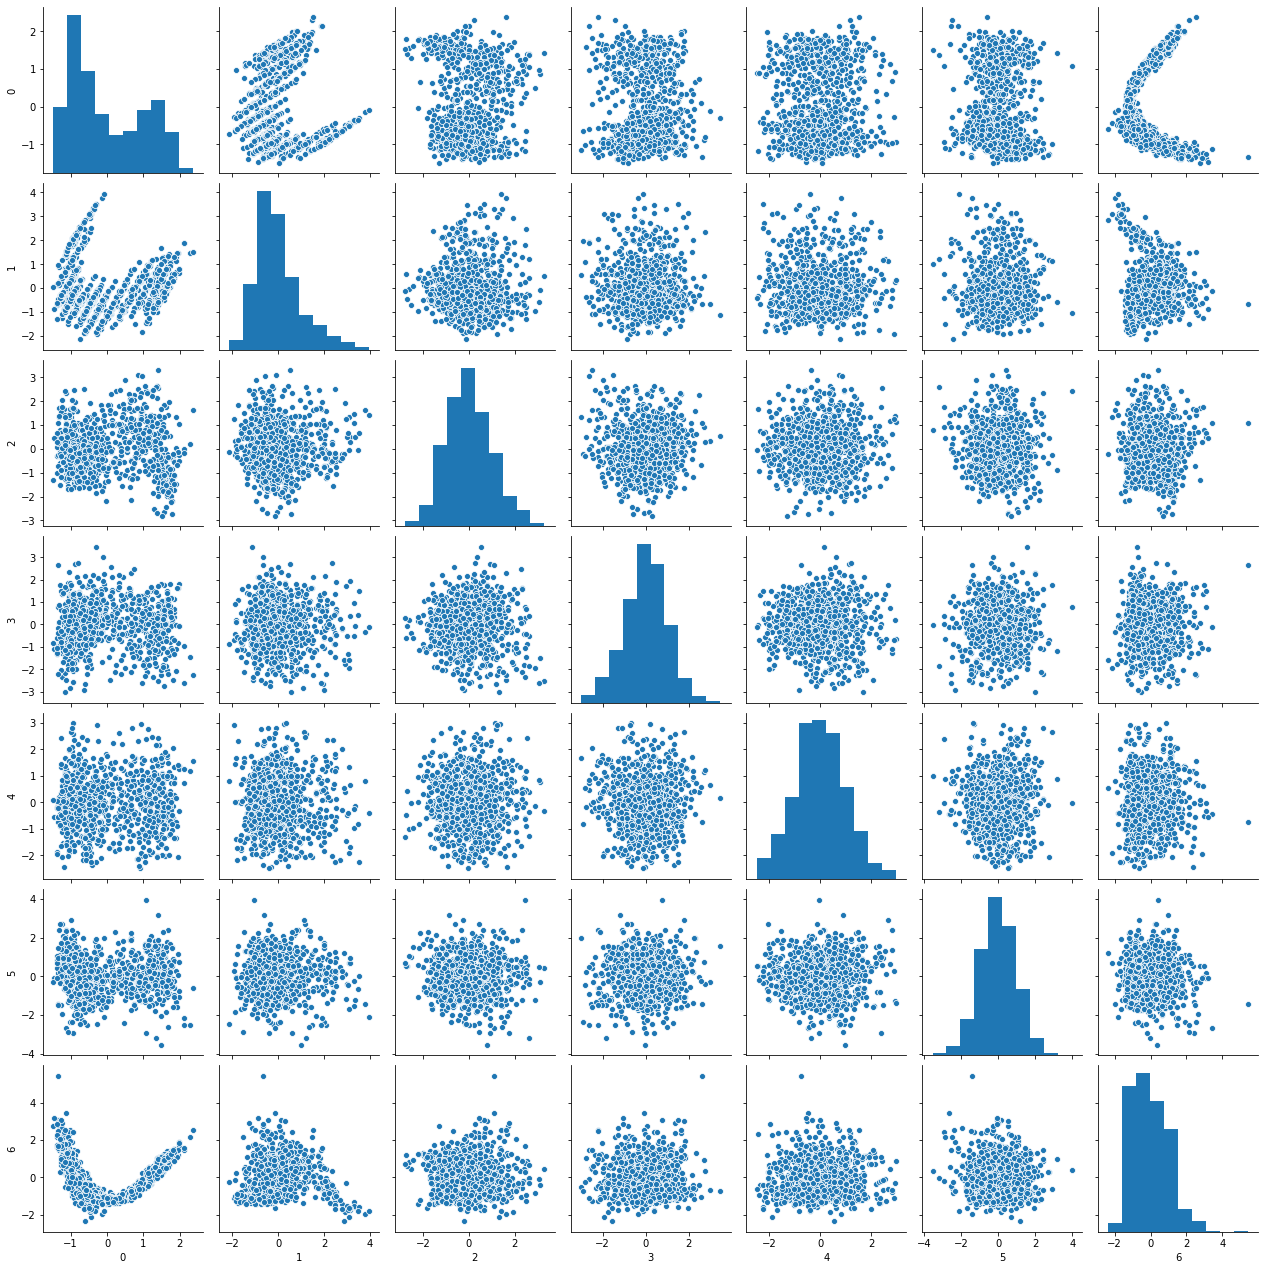

In [18]:
from sklearn.decomposition import PCA

correlation_matrix = compute_correlation(city_data);
sorted_features = correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False);

transform = PCA(whiten=True);
city_pcaed = pd.DataFrame(transform.fit_transform(city_data[sorted_features.index[:7]]));
# city_pcaed['total_cases'] = city_data['total_cases'];
sns_plot = sns.pairplot(city_pcaed);

We can see that there is still no linear relationship with `total_cases`, but at least every variable is uncorrelated.

# Modelling
We attempt to model what happens with data using machine learning without any kind of temporal analysis, just for fun.

In [19]:
from sklearn.model_selection import train_test_split 

n_features =7;
X = city_data[sorted_features.index[:n_features]];
X_pca = city_pcaed;
y = labels;

i_train, i_test = train_test_split(X.index, train_size = .85, shuffle=False);

# We need to scale this data
X_train = X.iloc[i_train];
X_test = X.iloc[i_test];

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler();
X_train = X_scaler.fit_transform(X_train);
X_test = X_scaler.transform(X_test);


# We don't need to scale pca data since we whitened it.
X_pca_train = X_pca.iloc[i_train];
X_pca_test = X_pca.iloc[i_test];


# We need to scale labels as well.
y_train = y['total_cases'].iloc[i_train];
y_test = y['total_cases'].iloc[i_test]; 

from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler((0,1));
y_train = y_scaler.fit_transform(np.expand_dims(y_train, axis=1));
y_test = y_scaler.transform(np.expand_dims(y_test, axis=1));

n_splits = 20;

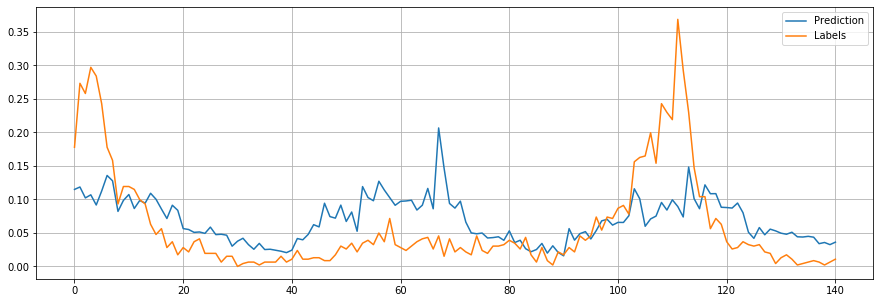

In [20]:
from ML_utils import Regressors
obj_reg = Regressors.Regressors()
obj_reg.get_regressor('KNN')
obj_reg.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
obj_reg.fit_model(X_train, y_train)

y_pred = obj_reg.return_prediction(X_test);
plt.figure(figsize=(15,5))
plt.plot(y_pred, label='Prediction')
plt.plot(y_test, label='Labels')
plt.grid()
plt.legend()

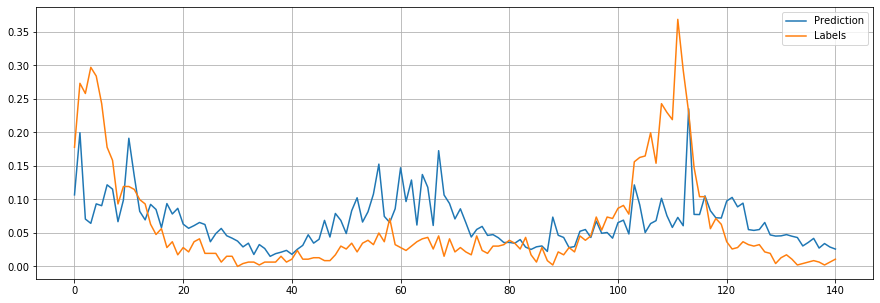

In [21]:
from ML_utils import Regressors
obj_reg = Regressors.Regressors()
obj_reg.get_regressor('KNN')
obj_reg.get_TimeSeries_CV('neg_mean_squared_error',n_splits)
obj_reg.fit_model(X_pca_train, y_train)

y_pred = obj_reg.return_prediction(X_pca_test);
plt.figure(figsize=(15,5))
plt.plot(y_pred, label='Prediction')
plt.plot(y_test, label='Labels')
plt.grid()
plt.legend()

# Model using `y` both as an input and output
In this case, we include data from previous estimations/labels as features. This means that if we are forecasting $y_n$, we will use both $X_n$ as well as $y_{n-memory:n-1}$ as features for our models.

In [22]:
n_features =7;
X = city_data[sorted_features.index[:n_features]];
X_pca = city_pcaed;
y = labels;
memory = 60;


from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler();
X = pd.DataFrame(X_scaler.fit_transform(X), columns=X.columns);

out = [list(y['total_cases'].iloc[np.arange(i-memory,i)].values) for i in np.arange(memory, X.shape[0])]
for j in range(memory):
    X.insert(1,'y_memory_{}'.format(j),0)
    X['y_memory_{}'.format(j)].iloc[memory:].values[:] = [vec[j] for vec in out];
    
    X_pca.insert(1, 'y_memory_{}'.format(j),0)    
    X_pca['y_memory_{}'.format(j)].iloc[memory:].values[:] =[vec[j] for vec in out];

In [23]:

i_train, i_test = train_test_split(X.index, train_size = .85, shuffle=False);

# We need to scale this data
X_train = X.iloc[i_train];
X_test = X.iloc[i_test];



# We don't need to scale pca data since we whitened it.
X_pca_train = X_pca.iloc[i_train];
X_pca_test = X_pca.iloc[i_test];


# We need to scale labels as well.
y_train = y['total_cases'].iloc[i_train];
y_test = y['total_cases'].iloc[i_test]; 

from sklearn.preprocessing import MinMaxScaler
y_train = y_train.values;
y_test = y_test.values;

n_splits = 20;

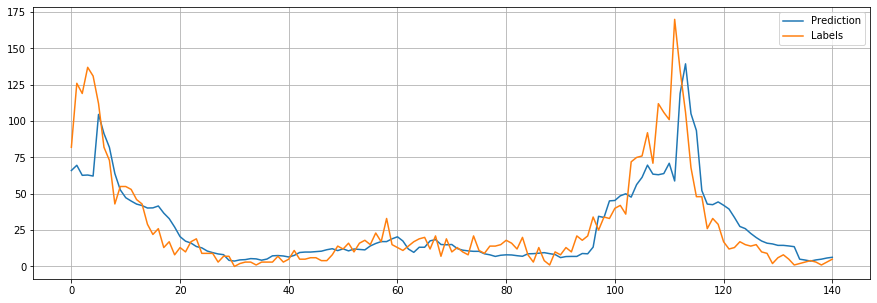

In [24]:
from ML_utils import Regressors
obj_reg = Regressors.Regressors()
obj_reg.get_regressor('KNN')
obj_reg.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
obj_reg.fit_model(X_train, y_train)

y_pred = obj_reg.return_prediction(X_test);
plt.figure(figsize=(15,5))
plt.plot(y_pred, label='Prediction')
plt.plot(y_test, label='Labels')
plt.grid()
plt.legend()

In [25]:
# from ML_utils import Regressors
# obj_reg = Regressors.Regressors()
# obj_reg.get_regressor('KNN')
# obj_reg.get_TimeSeries_CV('neg_mean_squared_error',n_splits)
# obj_reg.fit_model(X_pca_train, y_train)

# y_pred = obj_reg.return_prediction(X_pca_test);
# plt.figure(figsize=(15,5))
# plt.plot(y_pred, label='Prediction')
# plt.plot(y_test, label='Labels')
# plt.grid()
# plt.legend()

In the following test we verify if the system still behaves when we use $\hat{y}_{n-memory:n-1}$ instead of $y_{n-memory:n-1}$. The plot shows in green that the forecast is clearly worse, as it should be expected, since the data we are relying on is not the actual data. Consequently, such forecast includes a certain acummulation of errors, since it includes both forecast error from the current frame $n$ as well as from the previous $memory$ frames used in the prediction.

Nevertheless, this approach looks promising.

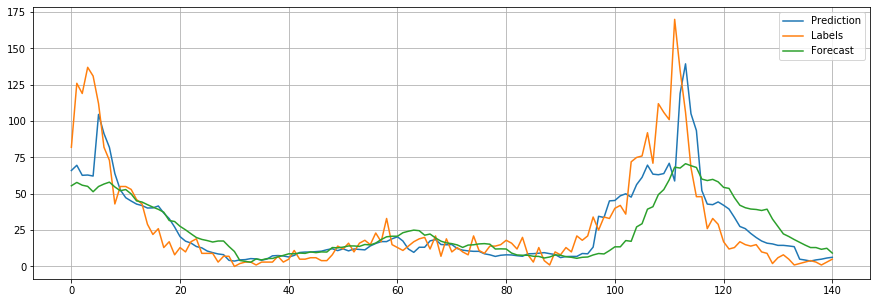

In [26]:

for j in range(memory):
    X_test['y_memory_{}'.format(j)].values[:] = 0

y_gen = []

for ind in range(X_test.shape[0]):
    if ind == 0:
        y_memory = [X_train.iloc[-1]['y_memory_{}'.format(j)] for j in range(memory)];
    else:
        y_memory[:memory] = y_memory[1:];
        y_memory.append( y_prev[0]);
    X_vector = X_test.iloc[ind]
    for j in range(memory):
        X_vector.at['y_memory_{}'.format(j)] = y_memory[j];

    y_prev = obj_reg.return_prediction(np.expand_dims(X_vector,axis=0));

    y_gen.append(y_prev[0])

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='Prediction')
plt.plot(y_test, label='Labels')
plt.plot(y_gen, label='Forecast')
plt.grid()
plt.legend()

# Forecasting values for the unknown dataset
The thing that remains to do consists of forecasting the values for the unknown dataset proposed for the challenge. In order to do so, we need to take into consideration the following aspects:
* First, we must keep the last temporal values for X and y, since they will be used for the first prediction we will made. 
* It is important to understand that our current predictions will depend strongly on past ones. Consequently, we will keep storing our forecasts as future values for the features `y_memory_n`.
* We have shown before an example analysis for one of the cities under analysis. We must duplicate our analysis to consider both towns.

First thing we do is training the model using the whole `X` and `y` sequences. We have not performed cross validation, but it is necessary to do it in order to get optimal memory parameters for the model, in addition to the optimal number of neighbors for KNN (as we did with `get_TimeSeries_CV()`). We leave that work for future works.

In [31]:
obj_opt = Regressors.Regressors()
obj_opt.get_regressor('KNN')
obj_opt.get_TimeSeries_CV('neg_mean_squared_error', n_splits)
obj_opt.fit_model(X, y['total_cases'])

In [36]:
unlabelled_features = read_data('dengue_features_test.csv');
unlabelled_features

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,...,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1


In [ ]:

for j in range(memory):
    X_test['y_memory_{}'.format(j)].values[:] = 0

y_gen = []

for ind in range(X_test.shape[0]):
    if ind == 0:
        y_memory = [X_train.iloc[-1]['y_memory_{}'.format(j)] for j in range(memory)];
    else:
        y_memory[:memory] = y_memory[1:];
        y_memory.append( y_prev[0]);
    X_vector = X_test.iloc[ind]
    for j in range(memory):
        X_vector.at['y_memory_{}'.format(j)] = y_memory[j];

    y_prev = obj_reg.return_prediction(np.expand_dims(X_vector,axis=0));

    y_gen.append(y_prev[0])

plt.figure(figsize=(15,5))
plt.plot(y_pred, label='Prediction')
plt.plot(y_test, label='Labels')
plt.plot(y_gen, label='Forecast')
plt.grid()
plt.legend()